##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-01-22 13:56:30--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 173.194.202.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   148MB/s    in 0.6s    

2021-01-22 13:56:30 (148 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [3]:
# keras.application으로 저장된 모델의 구조를 불러옴
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)
# 모델의 weights를 불러옴
pre_trained_model.load_weights(local_weights_file)

In [4]:
for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

# 모델의 특정 지점에서 DNN을 연결함
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output 

last layer output shape:  (None, 7, 7, 768)


In [5]:
from tensorflow.keras.optimizers import RMSprop

# 모델의 마지막 output에 DNN layer를 추가하여 원하는 결과값이 나올 수 있도록 조정
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])


In [6]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

--2021-01-22 13:56:33--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 74.125.20.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   175MB/s    in 0.4s    

2021-01-22 13:56:34 (175 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 23s - loss: 0.3579 - accuracy: 0.8590 - val_loss: 0.1084 - val_accuracy: 0.9560
Epoch 2/20
100/100 - 17s - loss: 0.2123 - accuracy: 0.9195 - val_loss: 0.1218 - val_accuracy: 0.9590
Epoch 3/20
100/100 - 17s - loss: 0.2108 - accuracy: 0.9255 - val_loss: 0.1059 - val_accuracy: 0.9600
Epoch 4/20
100/100 - 17s - loss: 0.1807 - accuracy: 0.9385 - val_loss: 0.1116 - val_accuracy: 0.9580
Epoch 5/20
100/100 - 17s - loss: 0.2054 - accuracy: 0.9335 - val_loss: 0.1328 - val_accuracy: 0.9570
Epoch 6/20
100/100 - 17s - loss: 0.1855 - accuracy: 0.9325 - val_loss: 0.1125 - val_accuracy: 0.9620
Epoch 7/20
100/100 - 17s - loss: 0.1748 - accuracy: 0.9415 - val_loss: 0.1431 - val_accuracy: 0.9600
Epoch 8/20
100/100 - 17s - loss: 0.1655 - accuracy: 0.9385 - val_loss: 0.1307 - val_accuracy: 0.9580
Epoch 9/20
100/100 - 17s - loss: 0.1550 - accuracy: 0.9415 - val_loss: 0.1130 - val_accuracy: 0.9630
Epoch 10/20
100/100 - 17s - loss: 0.1374 - accuracy: 0.9545 - val_loss: 0.1289 - val_accura

결과 그래프를 살펴봅니다.

* Training acc는 잘 올라기고 있음
* Validation acc는 처음보다 감소하기도 함
  -> 학습 데이터에 과적합(overfitting)된 것으로 의심할 수 있음

* 두 acc 그래프가 동일하게 상승하는 모양이 나타나면 모델의 학습이 잘 이루어지고 있다고 판단할 수 있음

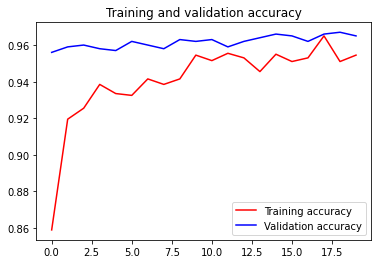

<Figure size 432x288 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

## 실습과정

1. keras.application으로 모델을 불러오고 미리 저장된 weights를 넣는다.
1. 고양이 sv 개 데이터셋을 불러온다
2. ImageGenerator를 사용하기 위해서 분류한다.

In [9]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-01-22 14:02:21--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.195.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   180MB/s    in 0.5s    

2021-01-22 14:02:21 (180 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [10]:
# keras.application으로 저장된 모델의 구조를 불러옴
from tensorflow.keras.applications.inception_v3 import InceptionV3


In [11]:
pre_trained_model = InceptionV3(include_top=False, input_shape=(150, 150, 3), weights=None)
pre_trained_model.load_weights('/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [12]:
# 모델의 weights를 고정함
for layer in pre_trained_model.layers:
  layer.trainable = False

In [13]:
# 원하는 layer의 output을 가져옴
last_layer = pre_trained_model.layers[-1]
output = last_layer.output

# DNN layer를 연결
x = layers.Flatten()(output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

# 모델 완성
model = Model(pre_trained_model.input, x)
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

--2021-01-22 14:02:23--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 142.250.99.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   115MB/s    in 0.6s    

2021-01-22 14:02:24 (115 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [15]:
local_zip = '//tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

In [16]:
base_dir = '/tmp/cats_and_dogs_filtered'
print(os.listdir(base_dir))

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

['validation', 'train', 'vectorize.py']


In [17]:
# ImageGenerator 정의

train_datagen = ImageDataGenerator(rescale=1/255, rotation_range=70, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1/255)

In [18]:
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=64, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150, 150), batch_size=32, class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [19]:
# for steps_per_epoch
2000 / 64, 1000/ 32

(31.25, 31.25)

In [20]:
histotry = model.fit_generator(train_generator, steps_per_epoch=32, epochs=10, verbose=2, validation_data=validation_generator)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
32/32 - 22s - loss: 13.5376 - accuracy: 0.7500 - val_loss: 1.0829 - val_accuracy: 0.9340
Epoch 2/10
32/32 - 16s - loss: 2.9742 - accuracy: 0.8280 - val_loss: 0.7182 - val_accuracy: 0.9360
Epoch 3/10
32/32 - 17s - loss: 1.4440 - accuracy: 0.8645 - val_loss: 0.2692 - val_accuracy: 0.9590
Epoch 4/10
32/32 - 16s - loss: 0.5933 - accuracy: 0.8240 - val_loss: 0.2895 - val_accuracy: 0.8620
Epoch 5/10
32/32 - 16s - loss: 0.6003 - accuracy: 0.8195 - val_loss: 0.1174 - val_accuracy: 0.9550
Epoch 6/10
32/32 - 16s - loss: 0.7169 - accuracy: 0.8385 - val_loss: 0.3858 - val_accuracy: 0.9120
Epoch 7/10
32/32 - 16s - loss: 0.3670 - accuracy: 0.8700 - val_loss: 0.2671 - val_accuracy: 0.9080
Epoch 8/10
32/32 - 16s - loss: 0.3472 - accuracy: 0.8715 - val_loss: 0.1161 - val_accuracy: 0.9520
Epoch 9/10
32/32 - 16s - loss: 0.4632 - accuracy: 0.8685 - val_loss: 0.1145 - val_accuracy: 0.9550
Epoch 10/10
32/32 - 16s - loss: 0.3050 - accuracy: 0.8965 - val_loss: 0.1142 - val_accuracy: 0.9600


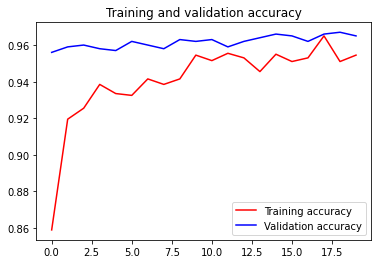

<Figure size 432x288 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r',label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()